In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, F1Score, AUC
from sklearn.metrics import classification_report, confusion_matrix, auc, roc_curve

import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

In [4]:
def segmentation(img):
    ## Segmentasi
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # blurred = cv2.GaussianBlur(img, (5, 5), 0)
    img = cv2.convertScaleAbs(img)

    # Apply Otsu's Thresholding
    ret, thresholded_image = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    thresholded_image = np.float32(thresholded_image)
    thresholded_image = np.stack([thresholded_image] * 3, axis=-1)
     
    return thresholded_image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


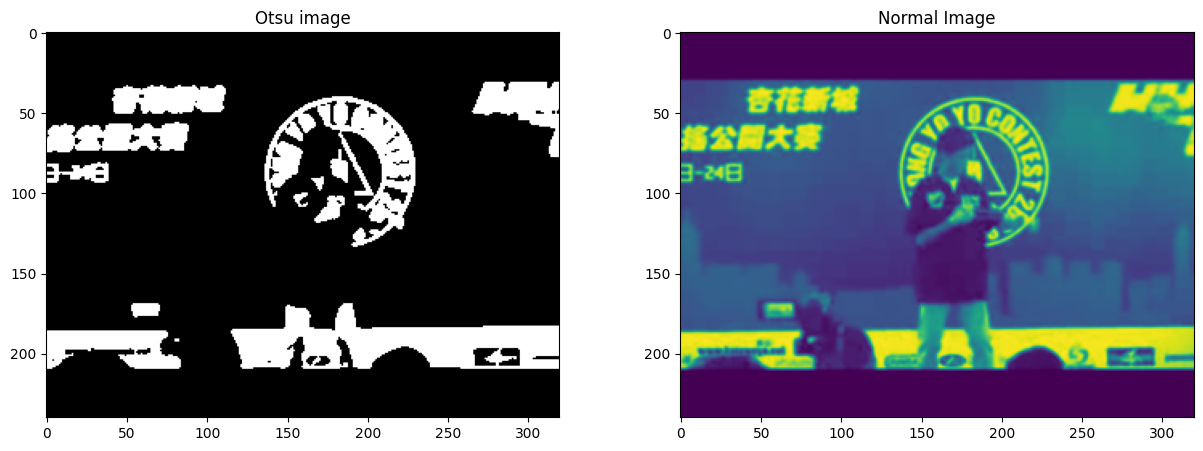

In [5]:
img = cv2.imread('./output/gaussian_cs/YoYo/v_YoYo_g01_c02/frame_0002.png')
grayscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
otsu = segmentation(grayscale)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.imshow(otsu)
plt.title('Otsu image')
plt.subplot(1,2,2)
plt.imshow(grayscale)
plt.title('Normal Image')
plt.show()

### Without Segmentation

In [ ]:
train_datagen = ImageDataGenerator(
    # preprocessing_function=segmentation,
    rescale=1./255,
    rotation_range=30,
    horizontal_flip=True,
    shear_range=0.2,
    validation_split=0.2,
    fill_mode='wrap'
)

train_generator = train_datagen.flow_from_directory(
    './output/gaussian_cs',
    target_size=(299,299),
    batch_size=32,
    class_mode = 'categorical',
    subset='training',
    shuffle=False
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

val_generator = val_datagen.flow_from_directory(
    './output/gaussian_cs',
    target_size=(299,299),   
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 50627 images belonging to 2 classes.
Found 12656 images belonging to 2 classes.


In [ ]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
base_model.trainable = False
num_classes = len(train_generator.class_indices)


model = tf.keras.models.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall(), F1Score()])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 8, 8, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         2,050 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,903,010 (91.18 MB)

 Trainable params: 2,100,226 (8.01 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [ ]:
# if os.path.exists('model_non_segmentation.keras'):
#     model = tf.keras.models.load_model('model_non_segmentation.keras')
# else:
history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples,
        epochs=20,
        validation_data=val_generator,
        validation_steps=val_generator.samples
    )

Epoch 1/10
50627/50627 ━━━━━━━━━━━━━━━━━━━━ 3350s 66ms/step - accuracy: 0.9997 - f1_score: 0.9996 - loss: 0.0012 - precision: 0.9997 - recall: 0.9997 - val_accuracy: 0.9603 - val_f1_score: 0.9582 - val_loss: 0.1054 - val_precision: 0.9603 - val_recall: 0.9603
Epoch 2/10
50627/50627 ━━━━━━━━━━━━━━━━━━━━ 3196s 63ms/step - accuracy: 0.9995 - f1_score: 0.9995 - loss: 0.0016 - precision: 0.9995 - recall: 0.9995 - val_accuracy: 0.9384 - val_f1_score: 0.9359 - val_loss: 0.2435 - val_precision: 0.9384 - val_recall: 0.9384
Epoch 3/10
50627/50627 ━━━━━━━━━━━━━━━━━━━━ 3093s 61ms/step - accuracy: 0.9996 - f1_score: 0.9996 - loss: 0.0012 - precision: 0.9996 - recall: 0.9996 - val_accuracy: 0.9733 - val_f1_score: 0.9717 - val_loss: 0.0736 - val_precision: 0.9733 - val_recall: 0.9733
Epoch 4/10
50627/50627 ━━━━━━━━━━━━━━━━━━━━ 3327s 66ms/step - accuracy: 0.9999 - f1_score: 0.9999 - loss: 4.2573e-04 - precision: 0.9999 - recall: 0.9999 - val_accuracy: 0.9755 - val_f1_score: 0.9740 - val_loss: 0.0656 -

KeyboardInterrupt: 

In [ ]:
# Mendapatkan nilai akurasi untuk setiap epoch dari history
train_accuracy = history.history['accuracy']  # Akurasi pada data training
val_accuracy = history.history['val_accuracy']  # Akurasi pada data validasi

# Mencetak akurasi di setiap epoch
print("Training Accuracy per Epoch:")
for epoch, acc in enumerate(train_accuracy, 1):
    print(f"Epoch {epoch}: {acc:.4f}")

print("\nValidation Accuracy per Epoch:")
for epoch, val_acc in enumerate(val_accuracy, 1):
    print(f"Epoch {epoch}: {val_acc:.4f}")

Training Accuracy per Epoch:
Epoch 1: 0.9948
Epoch 2: 0.9974
Epoch 3: 0.9979
Epoch 4: 0.9983
Epoch 5: 0.9979
Epoch 6: 0.9988
Epoch 7: 0.9989
Epoch 8: 0.9988
Epoch 9: 0.9989
Epoch 10: 0.9988

Validation Accuracy per Epoch:
Epoch 1: 0.9825
Epoch 2: 0.9388
Epoch 3: 0.9385
Epoch 4: 0.9923
Epoch 5: 0.9684
Epoch 6: 0.9908
Epoch 7: 0.9810
Epoch 8: 0.9174
Epoch 9: 0.9863
Epoch 10: 0.9305


In [ ]:
test_images, test_labels = next(val_generator)

test_images = test_images[:10]
test_labels = test_labels[:10]

predictions = model.predict(test_images)

predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_labels, axis=1)

# Tampilkan hasil prediksi untuk 10 data
for i in range(10):
    print(f"Predicted: {predicted_classes[i]}, True: {true_classes[i]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted: 0, True: 0
Predicted: 0, True: 0
Predicted: 0, True: 0
Predicted: 0, True: 0
Predicted: 1, True: 1
Predicted: 1, True: 0
Predicted: 1, True: 1
Predicted: 0, True: 0
Predicted: 0, True: 0
Predicted: 1, True: 1


In [ ]:
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels from the test generator
y_true = val_generator.classes  # True class labels

# Get class names from the generator
class_names = list(val_generator.class_indices.keys())

# Generate the classification report
report = classification_report(y_true, y_pred_classes, target_names=class_names)
print("Classification Report:\n", report)

# Optional: Confusion matrix for additional insights
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:\n", conf_matrix)

396/396 ━━━━━━━━━━━━━━━━━━━━ 546s 1s/step
Classification Report:
                precision    recall  f1-score   support

PlayingGuitar       0.62      0.56      0.59      7986
         YoYo       0.36      0.43      0.39      4670

     accuracy                           0.51     12656
    macro avg       0.49      0.49      0.49     12656
 weighted avg       0.53      0.51      0.52     12656

Confusion Matrix:
 [[4439 3547]
 [2670 2000]]


In [ ]:
y_pred_proba = y_pred[:, 1]
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)

roc_auc = auc(fpr, tpr)

# Visualisasi ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)  # Garis acak
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

print(f"AUC: {roc_auc:.2f}")


In [ ]:
model.save('model_non_segmentation.keras')

### Segmentation

In [ ]:
train_datagen = ImageDataGenerator(
    preprocessing_function=segmentation,
    rescale=1./255,
    rotation_range=30,
    horizontal_flip=True,
    shear_range=0.2,
    validation_split=0.2,
    fill_mode='wrap'
)

train_generator = train_datagen.flow_from_directory(
    './output/gaussian_cs',
    target_size=(299,299),
    batch_size=32,
    class_mode = 'categorical',
    subset='training'
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

val_generator = val_datagen.flow_from_directory(
    './output/gaussian_cs',
    target_size=(299,299),   
    batch_size=32,
    class_mode='categorical',
    subset='validation',
)

In [ ]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
base_model.trainable = False
num_classes = len(train_generator.class_indices)


model = tf.keras.models.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall(), F1Score()])

model.summary()

In [ ]:
history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples,
        epochs=20,
        validation_data=val_generator,
        validation_steps=val_generator.samples
    )

In [ ]:
# Mendapatkan nilai akurasi untuk setiap epoch dari history
train_accuracy = history.history['accuracy']  # Akurasi pada data training
val_accuracy = history.history['val_accuracy']  # Akurasi pada data validasi

# Mencetak akurasi di setiap epoch
print("Training Accuracy per Epoch:")
for epoch, acc in enumerate(train_accuracy, 1):
    print(f"Epoch {epoch}: {acc:.4f}")

print("\nValidation Accuracy per Epoch:")
for epoch, val_acc in enumerate(val_accuracy, 1):
    print(f"Epoch {epoch}: {val_acc:.4f}")

In [ ]:
test_images, test_labels = next(val_generator)

test_images = test_images[:10]
test_labels = test_labels[:10]

predictions = model.predict(test_images)

predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_labels, axis=1)

# Tampilkan hasil prediksi untuk 10 data
for i in range(10):
    print(f"Predicted: {predicted_classes[i]}, True: {true_classes[i]}")

In [ ]:
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels from the test generator
y_true = val_generator.classes  # True class labels

# Get class names from the generator
class_names = list(val_generator.class_indices.keys())

# Generate the classification report
report = classification_report(y_true, y_pred_classes, target_names=class_names)
print("Classification Report:\n", report)

# Optional: Confusion matrix for additional insights
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:\n", conf_matrix)

In [ ]:
model.save('model_segmentation.keras')